# Imports

In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer

In [2]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [3]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [4]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_ciclo1_multiclass_aug_dim_135_TIs_TargetPerc.pkl')
print(df.shape)
df.head(2)

(139884, 135)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,122.7500,160.0,11,2,2,15.0,HOLD,1,106.82,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,126.8625,205.0,11,2,2,50.0,HOLD,1,106.83,HOLD


## Split dos Dados

In [5]:
df.columns.tolist()
df.columns.array

<PandasArray>
[             'DATETIME',                  'DATE',                  'TIME',
                  'OPEN',                  'HIGH',                   'LOW',
                 'CLOSE',                   'VOL',        'BBANDS_Upper_5',
        'BBANDS_Lower_5',
 ...
                'ATR_20',                'TRANGE',                   'MES',
            'DIA_SEMANA',            'HORA_NOBRE',            'TARGET_WIN',
       'TARGET_WIN_CAT3', 'TARGET_WIN_CAT3_LABEL',      'PRICE_PERCENTAGE',
     'TARGET_PERCENTAGE']
Length: 135, dtype: object

In [6]:
print(df.shape)
df2 = df.drop([  'OPEN',                  
                 'HIGH',                   
                 'LOW',
                 'CLOSE',                   
                 'VOL',
                 'TARGET_WIN',
                 'TARGET_WIN_CAT3', 
                 'TARGET_WIN_CAT3_LABEL',      
                 'PRICE_PERCENTAGE'
               
            
              ], axis=1)
print(df2.shape)
df2.head(2)

(139884, 135)
(139884, 126)


,DATETIME,DATE,TIME,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,...,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53752.526189,53227.473811,53701.563032,53003.436968,53582.216054,52961.783946,53513.521581,...,16995.0,183.08836,157.567344,133.163314,122.7500,160.0,11,2,2,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53712.281525,53317.718475,53699.874976,53060.125024,53596.604149,52972.395851,53498.711770,...,24029.0,190.39224,165.472787,139.149704,126.8625,205.0,11,2,2,HOLD


In [7]:
df3 = df2[df2['DATETIME'].dt.year < 2020]
df3.drop(['DATE', 'TIME'], axis=1, inplace=True)
df4 = df3[df3['DATETIME'].dt.year > 2014].reset_index(drop=True)
df4

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,DATETIME,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,EMA_5_CLOSE,EMA_10_CLOSE,...,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
0,2015-01-02 09:00:00,50378.309519,50261.690481,50497.291502,50233.708498,50969.316517,50075.683483,50268.727226,50325.205919,50381.098425,...,-165899.0,118.566120,105.950934,106.052199,107.965299,235.0,1,4,0,HOLD
1,2015-01-02 09:05:00,50356.614552,50271.385448,50497.291502,50233.708498,50873.822404,50101.177596,50273.919204,50328.470612,50372.716893,...,-164931.0,140.710746,119.125779,112.631182,111.817034,185.0,1,4,0,SELL
2,2015-01-02 09:10:00,50357.744230,50260.255770,50499.674891,50219.325109,50786.278237,50122.221763,50262.885100,50313.980408,50356.768367,...,-165756.0,138.807164,121.771482,114.495250,112.976182,135.0,1,4,0,SELL
3,2015-01-02 09:15:00,50352.923020,50249.076980,50475.710360,50209.289640,50711.656890,50139.843110,50254.576813,50302.653605,50342.810482,...,-166162.0,125.871443,118.142902,113.287313,112.327373,100.0,1,4,0,SELL
4,2015-01-02 09:20:00,50366.509358,50179.490642,50433.928992,50191.071008,50648.003968,50143.996032,50220.103436,50265.102404,50315.026758,...,-167120.0,118.914295,115.952418,112.596703,111.961004,105.0,1,4,0,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132938,2019-12-30 17:45:00,116667.659125,116078.340875,116774.216137,116181.783863,116782.959522,116293.540478,116323.065785,116340.624588,116429.656185,...,-7927844.0,179.921938,145.712683,126.369144,125.228206,155.0,12,0,2,SELL
132939,2019-12-30 17:50:00,116549.852901,116006.147099,116788.622542,116070.377458,116821.467071,116206.532929,116235.121499,116262.083059,116370.627788,...,-7988477.0,188.281292,155.593903,132.921715,129.216796,205.0,12,0,2,SELL
132940,2019-12-30 17:55:00,116547.693506,115856.306494,116802.469722,115935.530278,116867.571155,116098.928845,116128.972961,116166.388706,116298.695463,...,-8061266.0,213.854195,173.828252,143.928239,136.005956,265.0,12,0,2,BUY
132941,2019-12-30 18:00:00,116333.405786,115842.594214,116786.572274,115821.427726,116902.018549,115998.981451,116036.295907,116085.925804,116230.750833,...,-8104891.0,199.236130,173.190210,146.100886,137.705658,170.0,12,0,2,BUY


In [8]:
df_train = df2[(df2['DATETIME'] >= '2015-01-01') & (df2['DATETIME'] < '2018-01-01')]
#df_train = df2[(df2['DATETIME'] >= '2017-12-01') & (df2['DATETIME'] < '2019-07-01')]
#df_train = df_train.iloc[-10000:, :]

#df_train = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-07-01')]

#----------------------------------------------------------------------------------------------------

df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-01-01')]
#df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-03-01')]
#df_valid = df_valid.iloc[:6600, :]

#df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-01-01')]

#----------------------------------------------------------------------------------------------------

df_test  = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2020-01-01')]
#df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#df_test  = df2[(df2['DATETIME'] < '2017-12-01')]
#df_test = df_test.iloc[:500,:]

#df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#----------------------------------------------------------------------------------------------------

print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df2['DATETIME'].count()))

df_train.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_test.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
print(df_train.shape, df_valid.shape, df_test.shape)

Proporção Train: 57.0% | Validation: 18.9% | Test: 19.1%
(79795, 123) (26410, 123) (26738, 123)


C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
df_test.iloc[19:200].head(1)

,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,...,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
109098,88174.761226,88091.238774,88238.387032,87917.612968,88228.767784,87736.732216,88124.552197,88120.485588,88090.757497,88085.21074,...,-3220019.0,140.147904,138.857426,142.408421,142.348568,150.0,1,2,1,HOLD


In [10]:
df_train['TARGET_PERCENTAGE'].value_counts()

HOLD    57590
BUY     11165
SELL    11040
Name: TARGET_PERCENTAGE, dtype: int64

In [11]:
df_train['TARGET_PERCENTAGE'].value_counts()[0]

57590

In [12]:
hold_train = df_train['TARGET_PERCENTAGE'].value_counts()[0]
hold_valid = df_valid['TARGET_PERCENTAGE'].value_counts()[0]
hold_test = df_test['TARGET_PERCENTAGE'].value_counts()[0]

print('\nDados Categóricos de Treino -- BUY: %d | SELL: %d | HOLD: %d' % (df_train['TARGET_PERCENTAGE'].value_counts()[1], df_train['TARGET_PERCENTAGE'].value_counts()[2], hold_train))
print('\nDados Categóricos de Validação -- BUY: %d | SELL: %d | HOLD: %d' % (df_valid['TARGET_PERCENTAGE'].value_counts()[1], df_valid['TARGET_PERCENTAGE'].value_counts()[2], hold_valid))
print('\nDados Categóricos de Teste -- BUY: %d | SELL: %d | HOLD: %d' % (df_test['TARGET_PERCENTAGE'].value_counts()[1], df_test['TARGET_PERCENTAGE'].value_counts()[2], hold_test))



Dados Categóricos de Treino -- BUY: 11165 | SELL: 11040 | HOLD: 57590

Dados Categóricos de Validação -- BUY: 3779 | SELL: 3701 | HOLD: 18930

Dados Categóricos de Teste -- BUY: 2666 | SELL: 2453 | HOLD: 21619


In [13]:
df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()

HORA_NOBRE  TARGET_PERCENTAGE
0           HOLD                  3343
            BUY                    575
            SELL                   510
1           HOLD                 14467
            SELL                  3870
            BUY                   3802
2           HOLD                 39780
            BUY                   6788
            SELL                  6660
Name: TARGET_PERCENTAGE, dtype: int64

In [14]:
buy_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

buy_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

buy_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

print('\nDados Categóricos de Treino Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_train, sell_train, hold_train))
print('\nDados Categóricos de Validação Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_valid, sell_valid, hold_valid))
print('\nDados Categóricos de Teste Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_test, sell_test, hold_test))



Dados Categóricos de Treino Hora Nobre -- BUY: 3870 | SELL: 3802 | HOLD: 14467

Dados Categóricos de Validação Hora Nobre -- BUY: 1284 | SELL: 1220 | HOLD: 4816

Dados Categóricos de Teste Hora Nobre -- BUY: 1025 | SELL: 979 | HOLD: 5406


In [15]:
np.random.seed(2345)
porcentagem_selecao_train = (buy_train / hold_train)
amostra_train = np.random.choice( a=[0,1], size=hold_train, replace=True, 
                                   p=[1-porcentagem_selecao_train, porcentagem_selecao_train] )
print(len(amostra_train))
print(len(amostra_train[amostra_train == 1]))
print(len(amostra_train[amostra_train == 0]))

14467
3831
10636


In [16]:
np.random.seed(2345)
porcentagem_selecao_valid = (buy_valid / hold_valid)
amostra_valid = np.random.choice( a=[0,1], size=hold_valid, replace=True, 
                                   p=[1-porcentagem_selecao_valid, porcentagem_selecao_valid] )
print(len(amostra_valid))
print(len(amostra_valid[amostra_valid == 1]))
print(len(amostra_valid[amostra_valid == 0]))

4816
1290
3526


In [17]:
np.random.seed(2345)
porcentagem_selecao_test = (buy_test / hold_test)
amostra_test = np.random.choice( a=[0,1], size=hold_test, replace=True, 
                                   p=[1-porcentagem_selecao_test, porcentagem_selecao_test] )
print(len(amostra_test))
print(len(amostra_test[amostra_test == 1]))
print(len(amostra_test[amostra_test == 0]))

5406
1048
4358


In [18]:
df_train

,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,...,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
2874,50378.309519,50261.690481,50497.291502,50233.708498,50969.316517,50075.683483,50268.727226,50325.205919,50381.098425,50504.834778,...,-165899.0,118.566120,105.950934,106.052199,107.965299,235.0,1,4,0,HOLD
2875,50356.614552,50271.385448,50497.291502,50233.708498,50873.822404,50101.177596,50273.919204,50328.470612,50372.716893,50488.660037,...,-164931.0,140.710746,119.125779,112.631182,111.817034,185.0,1,4,0,SELL
2876,50357.744230,50260.255770,50499.674891,50219.325109,50786.278237,50122.221763,50262.885100,50313.980408,50356.768367,50469.263843,...,-165756.0,138.807164,121.771482,114.495250,112.976182,135.0,1,4,0,SELL
2877,50352.923020,50249.076980,50475.710360,50209.289640,50711.656890,50139.843110,50254.576813,50302.653605,50342.810482,50451.238715,...,-166162.0,125.871443,118.142902,113.287313,112.327373,100.0,1,4,0,SELL
2878,50366.509358,50179.490642,50433.928992,50191.071008,50648.003968,50143.996032,50220.103436,50265.102404,50315.026758,50426.358837,...,-167120.0,118.914295,115.952418,112.596703,111.961004,105.0,1,4,0,SELL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82664,76859.248077,76826.751923,76876.500000,76822.500000,76875.787293,76808.712707,76843.797427,76841.911072,76844.036400,76842.565363,...,-1431887.0,42.081982,41.723734,42.173451,42.577047,40.0,12,3,2,HOLD
82665,76859.435596,76824.564404,76867.613344,76823.386656,76875.741540,76809.258460,76840.853637,76839.607381,76842.393418,76841.844852,...,-1421538.0,48.054655,44.769779,43.658997,43.448194,60.0,12,3,2,HOLD
82666,76858.204651,76823.795349,76863.524984,76823.475016,76875.541640,76810.958360,76840.342384,76839.738254,76841.958251,76841.669152,...,-1414407.0,43.703103,43.141482,42.937414,43.025785,35.0,12,3,2,BUY
82667,76886.293765,76807.706235,76878.138584,76814.861416,76879.417530,76815.082470,76854.864856,76854.825503,76849.784024,76845.795899,...,-1407414.0,52.468735,47.617902,45.192629,44.374495,70.0,12,3,2,BUY


In [19]:
def normalize(data):

    scaler_x = StandardScaler()

    x = data.iloc[:, :-2]
    x = scaler_x.fit_transform(x) 

    y = data.iloc[:,-1]
    y_list = np.array(y.to_list())

    return x, y_list

In [20]:
def get_train_valid_test_data(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    for i in range(len(df) - seq_len):
        if df['TARGET_PERCENTAGE'][i+seq_len-1] == 'HOLD':
            if amostragem[a] == 0:
                df.drop((i+seq_len-1), axis=0, inplace=True) 
            a+=1

    x, y = normalize(df)

    return x, y

In [21]:
def next_window(i, seq_len, df):
    df = df[i:i+seq_len]
    scaler_x = StandardScaler()
    
    x = df.iloc[:, :-2]
    x = scaler_x.fit_transform(x) 
    
    y = df.iloc[-1,-1]
    # y_list = np.array(y.to_list())
    
    return x, y

In [22]:
def get_train_valid_test_data_Slide_Window(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    data_x = []
    data_y = []
    for i in range(len(df) - seq_len):
        if df['TARGET_PERCENTAGE'].iloc[i+seq_len-1] == 'HOLD':
            if amostragem[a] == 1:    
                x, y = next_window(i, seq_len, df)
                data_x.append(x)
                data_y.append(y)
            a+=1
        else:
            x, y = next_window(i, seq_len, df)
            data_x.append(x)
            data_y.append(y)

    return np.array(data_x), np.array(data_y)

In [23]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train, y_train = get_train_valid_test_data(seq_len=1, 
                                             df=df_train_reset_index, 
                                             amostragem=amostra_train)
print('x_train: ', x_train.shape,' | y_train: ', y_train.shape)

df.shape:  (22139, 123)
x_train:  (11503, 121)  | y_train:  (11503,)


In [24]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train_sw, y_train_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_train_reset_index, 
                                                                 amostragem=amostra_train)
print('x_train_sw: ', x_train_sw.shape,' | y_train_sw: ', y_train_sw.shape)

df.shape:  (22139, 123)
x_train_sw:  (11495, 20, 121)  | y_train_sw:  (11495,)


In [25]:
print(len(x_train), len(y_train))
print(len(x_train_sw), len(y_train_sw))

11503 11503
11495 11495


In [26]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid, y_valid = get_train_valid_test_data( seq_len=1, 
                                              df=df_valid_reset_index, 
                                              amostragem=amostra_valid )
print(x_valid.shape, y_valid.shape)

df.shape:  (7320, 123)
(3794, 121) (3794,)


In [27]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid_sw, y_valid_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_valid_reset_index, 
                                                                 amostragem=amostra_valid )
print(x_valid_sw.shape, y_valid_sw.shape)

df.shape:  (7320, 123)
(3789, 20, 121) (3789,)


In [28]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test, y_test = get_train_valid_test_data( seq_len=1, 
                                            df=df_test_reset_index, 
                                            amostragem=amostra_test )
print(x_test.shape, y_test.shape)

df.shape:  (7410, 123)
(3052, 121) (3052,)


In [29]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in y_test:
    if n == 'BUY':
        cont_buy+=1
    if n == 'HOLD':
        cont_hold+=1
    if n == 'SELL':
        cont_sell+=1

print('y_test.size: ', y_test.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

y_test.size:  3052  | cont_buy:  1025  | cont_hold:  1048  | cont_sell:  979


In [30]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test_sw, y_test_sw = get_train_valid_test_data_Slide_Window(   seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_test_reset_index, 
                                                                 amostragem=amostra_test)
print(x_test_sw.shape, y_test_sw.shape)

df.shape:  (7410, 123)
(3045, 20, 121) (3045,)


In [31]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in y_test_sw:
    if n == 'BUY':
        cont_buy+=1
    if n == 'HOLD':
        cont_hold+=1
    if n == 'SELL':
        cont_sell+=1

print('y_test_sw.size: ', y_test_sw.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

y_test_sw.size:  3045  | cont_buy:  1021  | cont_hold:  1046  | cont_sell:  978


In [32]:
print(len(x_train), len(y_train))
print(len(x_train_sw), len(y_train_sw))

11503 11503
11495 11495


## Cálculo do Weighted F Score

In [33]:
def weightedFScore(confusion_matrix):
    beta_1 = math.pow(0.5, 2)
    beta_2 = math.pow(0.25, 2)
    beta_3 = math.pow(0.125, 2)
    
    num_tu = confusion_matrix[[0],[0]]
    num_tf = confusion_matrix[[1],[1]]
    num_td = confusion_matrix[[2],[2]]
    
    wrongF_trueU = confusion_matrix[[0],[1]]
    wrongD_trueU = confusion_matrix[[0],[2]]
    
    wrongU_trueF = confusion_matrix[[1],[0]]
    wrongD_trueF = confusion_matrix[[1],[2]]
  
    wrongU_trueD = confusion_matrix[[2],[0]]
    wrongF_trueD = confusion_matrix[[2],[1]]
    
    num_tp = num_tu + num_td + (beta_3 * num_tf)
    erro_tipo_1 = wrongU_trueD + wrongD_trueU
    erro_tipo_2 = wrongU_trueF + wrongD_trueF
    erro_tipo_3 = wrongF_trueU + wrongF_trueD
    
    num = (1 + beta_1 + beta_2) * num_tp
    den = num + erro_tipo_1 + (beta_1 * erro_tipo_2) + (beta_2 * erro_tipo_3)
    
    wFScore = num / den
    
    return wFScore

# Modelos

In [34]:
import lightgbm as lgbm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## LightGBM

In [35]:
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=0, n_estimators=5000, learning_rate=0.001, num_leaves=2**6,
                                 subsample=0.9, subsample_freq=1, colsample_bytree=1.)

model_lgbm.fit(x_train, y_train)
predict_lgbm = model_lgbm.predict(x_test)

accuracy_score_LGBM = accuracy_score(y_test, predict_lgbm)

print('Accuracy Score - LightGBM: ', accuracy_score_LGBM)

Accuracy Score - LightGBM:  0.41448230668414154
              precision    recall  f1-score   support

         BUY       0.39      0.40      0.40      1025
        HOLD       0.46      0.51      0.48      1048
        SELL       0.38      0.33      0.35       979

    accuracy                           0.41      3052
   macro avg       0.41      0.41      0.41      3052
weighted avg       0.41      0.41      0.41      3052



In [ ]:
print(classification_report(y_test, predict_lgbm))

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_lgbm, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[411, 309, 305],
       [290, 532, 226],
       [341, 316, 322]], dtype=int64)

In [37]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in predict_lgbm:
    if n == 'BUY':
        cont_buy+=1
    if n == 'SELL':
        cont_sell+=1
    if n == 'HOLD':
        cont_hold+=1

print('predict_lgbm.size: ', predict_lgbm.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

predict_lgbm.size:  3052  | cont_buy:  1042  | cont_hold:  1157  | cont_sell:  853


<AxesSubplot:>

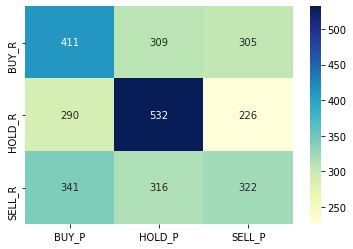

In [38]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LGBM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

In [39]:
weightedFScore_LGBM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LGBM

0.5444619557970714

### Compare train and test set accuracy

In [40]:
#y_pred_train = model_lgbm.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [41]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_lgbm.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_lgbm.score(x_test, y_test)))

In [42]:
#print('Validation set score: {:.4f}'.format(model_lgbm.score(x_valid, y_valid)))

## Random Forest

In [43]:
model_randomF = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=5000)
model_randomF.fit(x_train, y_train)
predict_randomF = model_randomF.predict(x_test)

accuracy_score_RF = accuracy_score(y_test, predict_randomF)
print('Accuracy Score - Random Forest: ', accuracy_score_RF)

Accuracy Score - Random Forest:  0.4272608125819135


In [44]:
print(classification_report(y_test, predict_randomF))

              precision    recall  f1-score   support

         BUY       0.40      0.40      0.40      1025
        HOLD       0.47      0.49      0.48      1048
        SELL       0.41      0.39      0.40       979

    accuracy                           0.43      3052
   macro avg       0.43      0.43      0.43      3052
weighted avg       0.43      0.43      0.43      3052



In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_randomF, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[407, 298, 320],
       [301, 512, 235],
       [314, 280, 385]], dtype=int64)

In [46]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in predict_randomF:
    if n == 'BUY':
        cont_buy+=1
    if n == 'SELL':
        cont_sell+=1
    if n == 'HOLD':
        cont_hold+=1

print('predict_randomF.size: ', predict_randomF.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

predict_randomF.size:  3052  | cont_buy:  1022  | cont_hold:  1090  | cont_sell:  940


<AxesSubplot:>

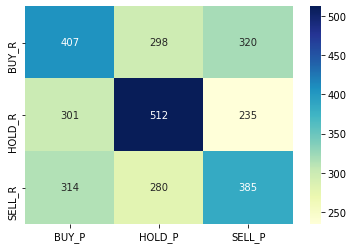

In [47]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_RF = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

In [48]:
weightedFScore_RF = weightedFScore(confusion_matrix)[0] 
weightedFScore_RF

0.5663048607833884

### Compare train and test set accuracy

In [49]:
#y_pred_train = model_randomF.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [50]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_randomF.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_randomF.score(x_test, y_test)))

In [51]:
#print('Validation set score: {:.4f}'.format(model_randomF.score(x_valid, y_valid)))

# Deep Learning

In [52]:
# Encoding categorical data
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def encode_categ_data(data):
    labelencoder = LabelEncoder()
    x = labelencoder.fit_transform(data)
    data_encoded = to_categorical(x)
    
    #print(data[10:20])
    #print(data_encoded[10:20])
    
    return data_encoded

Using TensorFlow backend.


In [53]:
# example of training a final classification model
from keras.models import Sequential, load_model
from core.utils import Timer
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam
dim = x_train.shape[1]

## DNN

In [54]:
# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(75, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(25, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[model] Model Compiled
Time taken: 0:00:00.662230


In [55]:
'''# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(30, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(15, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()
'''

"# define and fit the final model\ntimer = Timer()\ntimer.start()\n\nmodel_dnn = Sequential()\n\nmodel_dnn.add(Dense(100, input_dim=dim, activation='relu'))\nmodel_dnn.add(Dropout(0.2))\nmodel_dnn.add(Dense(50, activation='relu'))\nmodel_dnn.add(Dropout(0.3))\nmodel_dnn.add(Dense(30, activation='relu'))\nmodel_dnn.add(Dropout(0.3))\nmodel_dnn.add(Dense(15, activation='relu'))\nmodel_dnn.add(Dropout(0.2))\nmodel_dnn.add(Dense(3, activation='softmax'))\n\nmodel_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nprint('[model] Model Compiled')\n#print(model_dnn.summary())\ntimer.stop()\n"

In [56]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_DNN.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_enc = encode_categ_data(y_train)
y_valid_enc = encode_categ_data(y_valid)
H = model_dnn.fit( x_train, y_train_enc, validation_data=(x_valid, y_valid_enc), epochs=50, 
               callbacks=callbacks, workers=1 )

model_dnn.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started

Train on 11503 samples, validate on 3794 samples
Epoch 1/50
11503/11503 [==============================] - 5s 444us/step - loss: 1.1250 - accuracy: 0.3459 - val_loss: 1.0888 - val_accuracy: 0.3882
Epoch 2/50
11503/11503 [==============================] - 3s 275us/step - loss: 1.0918 - accuracy: 0.3796 - val_loss: 1.0863 - val_accuracy: 0.3822
Epoch 3/50
11503/11503 [==============================] - 3s 271us/step - loss: 1.0836 - accuracy: 0.3862 - val_loss: 1.0825 - val_accuracy: 0.3735
Epoch 4/50
11503/11503 [==============================] - 3s 250us/step - loss: 1.0798 - accuracy: 0.3989 - val_loss: 1.0784 - val_accuracy: 0.3838
Epoch 5/50
11503/11503 [==============================] - 3s 268us/step - loss: 1.0811 - accuracy: 0.3847 - val_loss: 1.0777 - val_accuracy: 0.3996
Epoch 6/50
11503/11503 [==============================] - 3s 248us/step - loss: 1.0759 - accuracy: 0.3900 - val_loss: 1.0762 - val_accuracy: 0.3951
Epoch 7/50
11503/11503 [=============

In [57]:
# new instances where we do not know the answer
y_pred = model_dnn.predict(x_test) 
y_pred

array([[0.36927798, 0.27027845, 0.36044353],
       [0.37483332, 0.25789678, 0.3672699 ],
       [0.3733418 , 0.26414427, 0.3625139 ],
       ...,
       [0.2827872 , 0.39850748, 0.31870535],
       [0.28054   , 0.40084222, 0.31861782],
       [0.29050112, 0.3867423 , 0.32275662]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


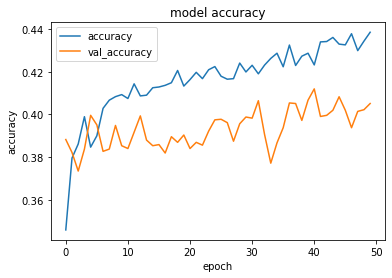

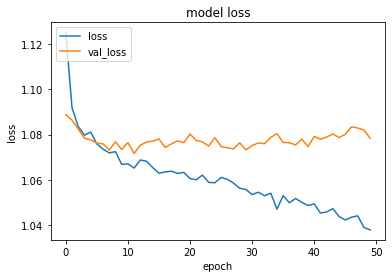

In [58]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [59]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_enc = encode_categ_data(y_test)
for i in y_test_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

In [60]:
print(y_pred[10:20])
print(y_test_enc[10:20])

[[0.37619248 0.25996074 0.36384678]
 [0.3823977  0.24850424 0.36909807]
 [0.33057496 0.33106837 0.33835664]
 [0.33824003 0.31959894 0.342161  ]
 [0.32876483 0.33069804 0.3405371 ]
 [0.36385778 0.27742064 0.35872155]
 [0.34068742 0.31401154 0.34530103]
 [0.34013984 0.31117484 0.34868532]
 [0.44397315 0.20729375 0.34873304]
 [0.37396917 0.26328817 0.3627427 ]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [61]:
print(pred_array[10:20])
print(real_array[10:20])

[0 0 2 2 2 0 2 2 0 0]
[1 1 1 0 1 0 0 0 2 0]


In [62]:
accuracy_score_DNN = accuracy_score(real_array, pred_array)
print('Accuracy Score - DL: ', accuracy_score_DNN)

Accuracy Score - DL:  0.4069462647444299


In [63]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.39      0.52      0.44      1025
           1       0.46      0.53      0.49      1048
           2       0.33      0.16      0.22       979

    accuracy                           0.41      3052
   macro avg       0.39      0.40      0.38      3052
weighted avg       0.39      0.41      0.39      3052



In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[529, 323, 173],
       [349, 554, 145],
       [489, 331, 159]], dtype=int64)

In [65]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in real_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('real_array.size: ', real_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

real_array.size:  3052  | cont_buy:  1025  | cont_hold:  1048  | cont_sell:  979


In [66]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in pred_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('pred_array.size: ', pred_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

pred_array.size:  3052  | cont_buy:  1367  | cont_hold:  1208  | cont_sell:  477


<AxesSubplot:>

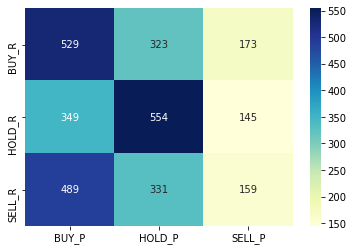

In [67]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_DNN = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

In [68]:
weightedFScore_DNN = weightedFScore(confusion_matrix)[0] 
weightedFScore_DNN

0.5252727327807803

In [69]:
y_pred_train = model_dnn.predict(x_train)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score: 0.4614


# LSTM

In [70]:
# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(LSTM(200, input_shape=(timesteps, dim), return_sequences=True))
#model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(150, input_shape=(timesteps, dim), return_sequences=True))
#model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()


[model] Model Compiled
Time taken: 0:00:01.739557


In [71]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_LSTM_activTanh.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_sw_enc = encode_categ_data(y_train_sw)
y_valid_sw_enc = encode_categ_data(y_valid_sw)
H = model_lstm.fit( x_train_sw, y_train_sw_enc, validation_data=(x_valid_sw, y_valid_sw_enc), epochs=15, 
                    batch_size=batch_size, callbacks=callbacks, workers=1 )

model_lstm.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
Train on 11495 samples, validate on 3789 samples
Epoch 1/15
11495/11495 [==============================] - 29s 3ms/step - loss: 1.0974 - accuracy: 0.3509 - val_loss: 1.0999 - val_accuracy: 0.3650
Epoch 2/15
11495/11495 [==============================] - 27s 2ms/step - loss: 1.0927 - accuracy: 0.3704 - val_loss: 1.0930 - val_accuracy: 0.3703
Epoch 3/15
11495/11495 [==============================] - 27s 2ms/step - loss: 1.0833 - accuracy: 0.4061 - val_loss: 1.0909 - val_accuracy: 0.3832
Epoch 4/15
11495/11495 [==============================] - 28s 2ms/step - loss: 1.0653 - accuracy: 0.4390 - val_loss: 1.1157 - val_accuracy: 0.3423
Epoch 5/15
11495/11495 [==============================] - 28s 2ms/step - loss: 1.0353 - accuracy: 0.4766 - val_loss: 1.1673 - val_accuracy: 0.3439
Epoch 6/15
11495/11495 [==============================] - 27s 2ms/step - loss: 1.0006 - accuracy: 0.5110 - val_loss: 1.1707 - val_accuracy: 0.3695
Epoch 7/15
11495/11495 [====================

In [72]:
# new instances where we do not know the answer
y_pred = model_lstm.predict(x_test_sw) 
y_pred

array([[0.03325853, 0.5311749 , 0.4355666 ],
       [0.05150363, 0.46929777, 0.47919858],
       [0.03000563, 0.53389627, 0.43609807],
       ...,
       [0.04227747, 0.38231084, 0.5754117 ],
       [0.0611128 , 0.4422419 , 0.49664533],
       [0.83072054, 0.14548245, 0.02379702]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


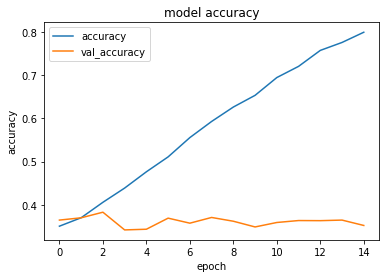

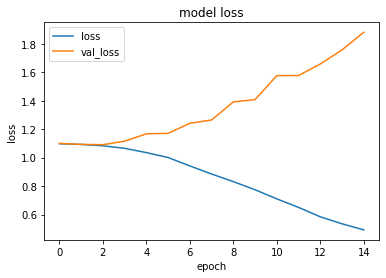

In [73]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [74]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_sw_enc = encode_categ_data(y_test_sw)
for i in y_test_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)   

In [75]:
print(y_pred[0:10])
print(pred_array[0:10])

[[3.3258531e-02 5.3117490e-01 4.3556660e-01]
 [5.1503632e-02 4.6929777e-01 4.7919858e-01]
 [3.0005626e-02 5.3389627e-01 4.3609807e-01]
 [6.7989086e-03 8.3561677e-01 1.5758429e-01]
 [3.1689361e-03 2.9941922e-02 9.6688908e-01]
 [3.3366419e-03 2.7558709e-02 9.6910471e-01]
 [5.9192539e-03 5.9207570e-02 9.3487322e-01]
 [1.1508701e-03 4.1318990e-02 9.5753008e-01]
 [8.7901577e-04 3.5796795e-02 9.6332419e-01]
 [3.7198819e-03 1.4886820e-01 8.4741187e-01]]
[1 2 1 1 2 2 2 2 2 2]


In [76]:
print(y_test_sw_enc[500:510])
print(real_array[500:510])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
[0 0 0 0 0 1 0 0 0 1]


In [77]:
y_pred.shape

(3045, 3)

In [78]:
pred_array.shape

(3045,)

In [79]:
y_test_sw_enc.shape

(3045, 3)

In [80]:
real_array.shape

(3045,)

In [81]:
accuracy_score_LSTM = accuracy_score(real_array, pred_array)
print('Accuracy Score - LSTM: ', accuracy_score_LSTM)

Accuracy Score - LSTM:  0.35073891625615766


In [82]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.35      0.27      0.30      1021
           1       0.38      0.36      0.37      1046
           2       0.33      0.43      0.37       978

    accuracy                           0.35      3045
   macro avg       0.35      0.35      0.35      3045
weighted avg       0.35      0.35      0.35      3045



In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[276, 314, 431],
       [258, 373, 415],
       [255, 304, 419]], dtype=int64)

In [84]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in real_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('real_array.size: ', real_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

real_array.size:  3045  | cont_buy:  1021  | cont_hold:  1046  | cont_sell:  978


In [85]:
cont_buy = 0
cont_sell = 0
cont_hold = 0
for n in pred_array:
    if n == 0:
        cont_buy+=1
    if n == 1:
        cont_hold+=1
    if n == 2:
        cont_sell+=1

print('pred_array.size: ', pred_array.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

pred_array.size:  3045  | cont_buy:  789  | cont_hold:  991  | cont_sell:  1265


In [86]:
weightedFScore_LSTM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LSTM

0.5074368998883213

<AxesSubplot:>

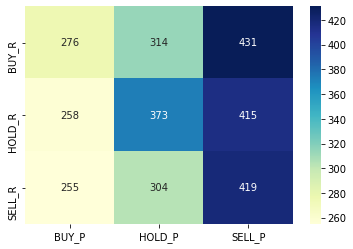

In [87]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LSTM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

In [88]:
y_pred_train_sw = model_lstm.predict(x_train_sw)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train_sw:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score LSTM: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score LSTM: 0.8318


# Resumo

In [89]:
print('-------------Resumo-------------')

print('\nAccuracy Score - LGBM: ', accuracy_score_LGBM)
print('Weighted F Score - LGBM: ', weightedFScore_LGBM)

print('\nAccuracy Score - Random Forest: ', accuracy_score_RF)
print('Weighted F Score - Random Forest: ', weightedFScore_RF)

print('\nAccuracy Score - DNN: ', accuracy_score_DNN)
print('Weighted F Score - DNN: ', weightedFScore_DNN)

print('\nAccuracy Score - LSTM: ', accuracy_score_LSTM)
print('Weighted F Score - LSTM: ', weightedFScore_LSTM)

-------------Resumo-------------

Accuracy Score - LGBM:  0.41448230668414154
Weighted F Score - LGBM:  0.5444619557970714

Accuracy Score - Random Forest:  0.4272608125819135
Weighted F Score - Random Forest:  0.5663048607833884

Accuracy Score - DNN:  0.4069462647444299
Weighted F Score - DNN:  0.5252727327807803

Accuracy Score - LSTM:  0.35073891625615766
Weighted F Score - LSTM:  0.5074368998883213


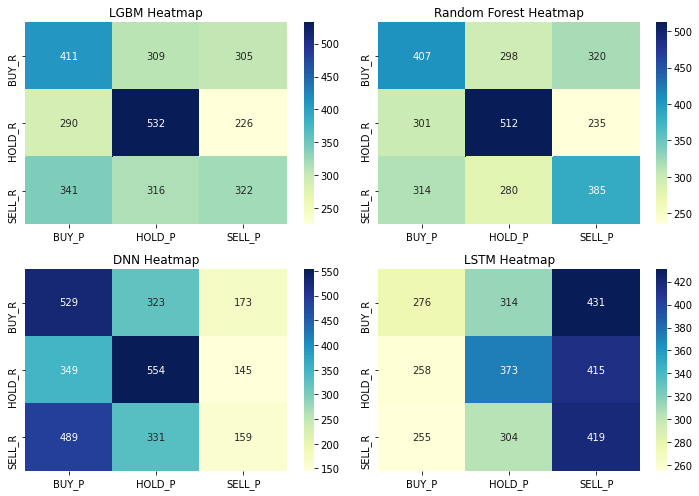

In [90]:
plt.figure(figsize=[10,7])
plt.subplot(2,2,1)
plt.title('LGBM Heatmap')
sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,2)
plt.title('Random Forest Heatmap')
sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,3)
plt.title('DNN Heatmap')
sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,4)
plt.title('LSTM Heatmap')
sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

plt.tight_layout()

In [94]:
# save trained model
pickle.dump( model_lgbm, open( 'saved_models/model_LGBM_135features_5000.pkl', 'wb' ) )

In [95]:
pickle.dump( model_dnn, open( 'saved_models/model_DNN_135features_50.pkl', 'wb' ) )

In [96]:
pickle.dump( model_randomF, open( 'saved_models/model_RF_135features_5000.pkl', 'wb' ) )